In [3]:
############
# Imports #
############

import json
import os

import wandb
import pandas as pd
import rasterio
import torch
import torchvision.utils as vutils
import numpy as np

from torch.utils.data import DataLoader
from PIL import Image

from model.cnn_classifier import model_4D
from model.pseudomask import Pseudomasks
from utils.data_modules import ImageDataset, TestSet, filter_dataset

##################
## load configs ##
##################

# use this path when using vs code debugger.
# config_path = os.path.join('/home/nadjaflechner/palsa_seg/current_models/pseudomask_generation_model', 'configs.json')

config_path = os.path.join(os.getcwd(), 'configs/pseudomasks_configs.json')
with open(config_path, 'r') as config_file:
    configs = json.load(config_file)

# assign paths
parent_dir = "/Volumes/USB/FINALFINAL_200m_groundtruths"
rgb_dir = os.path.join(parent_dir, 'rgb')
hs_dir = os.path.join(parent_dir, 'hs')
dem_dir = os.path.join(parent_dir, 'dem')
final_pseudomasks_dir = os.path.join(parent_dir, 'pseudomasks')
labels_file = '/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/new_palsa_labels.csv'

# load model configs dictionary
config_model = configs.get('model', {})
# assign model
artifact_path = config_model.get('artifact_path')
run_id = config_model.get('run_id')
finetune = config_model.get('finetuned')

# load data configs dictionary
config_data = configs.get('data', {})
# assign data configs
n_samples = config_data.get('n_samples')
batch_size = config_data.get('batch_size')
im_size = config_data.get('im_size')
min_palsa_positive_samples = config_data.get('min_palsa_positive_samples')
augment = config_data.get('augment')
normalize = config_data.get('normalize')
depth_layer = config_data.get('depth_layer')

# load pseudomasks configs dictionary
config_pseudomasks = configs.get('pseudomasks', {})
# assign pseudomasks configs
cam_threshold_factor = config_pseudomasks.get('cam_threshold_factor')
overlap_threshold = config_pseudomasks.get('overlap_threshold')
snic_seeds = config_pseudomasks.get('snic_seeds')
snic_compactness = config_pseudomasks.get('snic_compactness')


#########################
# configure dataloaders #
#########################

all_files = pd.read_csv(labels_file, index_col=0)
all_files = all_files[all_files['palsa_percentage']>0]

# choose depth data based on configs
depth_dir = hs_dir if depth_layer == "hs" else dem_dir
# Create the dataset and loaders for the entire dataset.
dataset = ImageDataset(depth_dir, rgb_dir, all_files, im_size, normalize)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

#############
# Init model: 

api = wandb.Api()
artifact = api.artifact(artifact_path, type='model')
artifact_dir = artifact.download()
state_dict = torch.load(f"{artifact_dir}/model.pth", map_location=torch.device('cpu'))
model = model_4D()
model.load_state_dict(state_dict)
model.eval()


wandb:   1 of 1 files downloaded.  


model_4D(
  (features): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(

In [3]:
len(all_files)

107

In [4]:
from torch.autograd import Variable
from torchmetrics.functional import jaccard_index
from torchmetrics.functional.classification import multiclass_accuracy

class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

# counter = 0
# bg_jaccard_scores = []
# target_jaccard_scores = []
# overall_accuracy = []
# target_accuracy = []
# bg_accuracy = []
# for img,binary_label,_,img_name in loader:

#     #get the last convolution
#     sf = SaveFeatures(model.features[-2])
#     im = Variable(img)
#     outputs = model(im)

#     # generate CAM
#     sf.remove()
#     arr = sf.features.cpu().detach()#.numpy()

#     pals_acts = torch.nn.functional.interpolate(
#         input = arr[:,1,:,:].unsqueeze(1),
#         scale_factor = 4,
#         mode='bilinear'
#     ).cpu().detach()
    
#     pixels_activated = torch.where(torch.Tensor(pals_acts) > 0.87, 1, 0).squeeze(0)

#     GT = rasterio.open(f"/Volumes/USB/FINALFINAL_200m_groundtruths/groundtruth_mask/{img_name[0]}.tif").read()
#     GT = torch.Tensor(GT)

#     # Calculate Jaccard score (IoU) for both classes
#     jaccard = jaccard_index(
#         pixels_activated, 
#         GT, 
#         task="multiclass", 
#         num_classes=2, 
#         average='none'
#     )
#     bg_jaccard_scores.append(jaccard[0])
#     target_jaccard_scores.append(jaccard[1])

#     # Overall accuracy
#     accuracy = multiclass_accuracy(
#         pixels_activated, 
#         GT, 
#         num_classes=2, 
#         average='micro'
#     )
#     overall_accuracy.append(accuracy)

#     # Overall accuracy
#     no_avg_accuracy = multiclass_accuracy(
#         pixels_activated, 
#         GT, 
#         num_classes=2, 
#         average='none'
#     )
#     bg_accuracy.append(no_avg_accuracy[0])
#     target_accuracy.append(no_avg_accuracy[1])

# avg_bg_jaccard = sum(bg_jaccard_scores) / len(bg_jaccard_scores)
# avg_target_jaccard = sum(target_jaccard_scores) / len(target_jaccard_scores)
# avg_overall_accuracy = sum(overall_accuracy) / len(overall_accuracy)
# avg_target_accuracy = sum(target_accuracy) / len(target_accuracy)
# avg_bg_accuracy = sum(bg_accuracy) / len(bg_accuracy)



In [22]:
print(f"avg_bg_jaccard = {avg_bg_jaccard}")
print(f"avg_target_jaccard = {avg_target_jaccard}")
print(f"avg_overall_accuracy = {avg_overall_accuracy}")
print(f"avg_target_accuracy = {avg_target_accuracy}")
print(f"avg_bg_accuracy = {avg_bg_accuracy}")

avg_bg_jaccard = 0.9021387100219727
avg_target_jaccard = 0.3057824373245239
avg_overall_accuracy = 0.9146012663841248
avg_target_accuracy = 0.5299164056777954
avg_bg_accuracy = 0.946975588798523


FileNotFoundError: [Errno 2] No such file or directory: '/root/Permafrost-Segmentation/Current_Version/pseudomasks/Verified_GTs/pseudomasks/masks/753_67_2550_2014_crop_51.png'

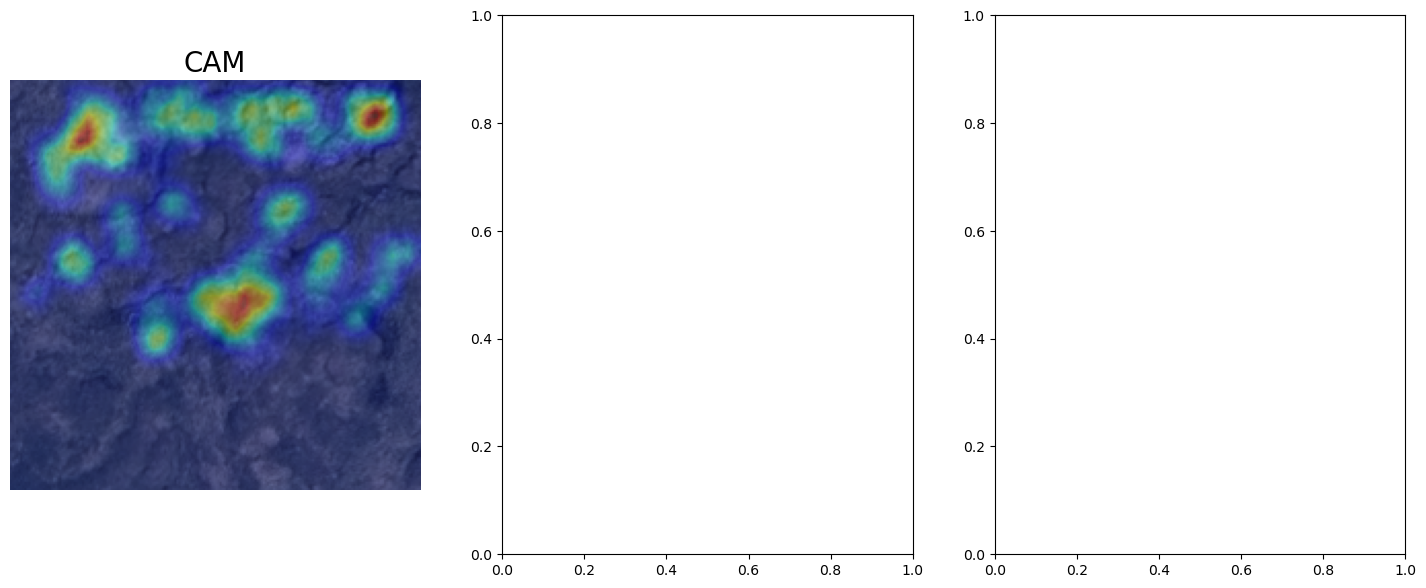

In [45]:
import torch.nn as nn
import matplotlib.pyplot as plt 

def plot_segmentation(filename):

    with rasterio.open(f"/Volumes/USB/FINALFINAL_200m_groundtruths/rgb/{filename}.tif") as RGB_src:
    # Read the image data
        RGB_img = RGB_src.read()

    with rasterio.open(f"/Volumes/USB/FINALFINAL_200m_groundtruths/hs/{filename}.tif") as hs_src:
        # Read the image data
        hs_img = hs_src.read()

    # convert and upsample hs image
    hs_image_array = np.array(hs_img)
    hs_image_tensor = torch.from_numpy(hs_image_array)
    hs_image_tensor = hs_image_tensor.float()
    bilinear = nn.Upsample(size=200*2, mode='bilinear')
    hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0)

    # converting RGB to tensor
    RGB_image_array = np.array(RGB_img)
    RGB_image_tensor = torch.from_numpy(RGB_image_array)
    RGB_image_tensor = RGB_image_tensor.float()

    combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor)).unsqueeze(dim=0)

    #get the last convolution
    sf = SaveFeatures(model.features[-2])
    im = Variable(combined_tensor)
    outputs = model(im)

    # generate CAM
    sf.remove()
    arr = sf.features.cpu().detach()

    pals_acts = torch.nn.functional.interpolate(
        input = arr[:,1,:,:].unsqueeze(1),
        scale_factor = 4,
        mode='bilinear'
    ).cpu().detach()
    
    cpu_img = combined_tensor.squeeze().cpu().detach().permute(1,2,0).long().numpy()

    # # Create color segmentation
    # color_seg = np.zeros((pixels_activated.shape[0],
    #                     pixels_activated.shape[1], 3), dtype=np.uint8) # height, width, 3

    # color = np.array([4, 250, 7])
    # # Fixing the IndexError by ensuring the correct indexing
    # color_seg[pixels_activated.squeeze().numpy() == 1, :] = color  # Changed from 0 to 1
    # # Convert to BGR
    # color_seg = color_seg[..., ::-1]

    # Overlay segmentation on image
    # img = np.array(RGB_img) * 0.5 + color_seg * 0.5
    # img = img.astype(np.uint8)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

    # CAM
    ax1.imshow(cpu_img[:,:,:3])
    ax1.imshow(pals_acts.view(pals_acts.shape[3], pals_acts.shape[3], 1), alpha=.4, cmap='jet')
    ax1.axis('off')
    ax1.set_title("CAM", size= 20)

    # Pseudomask
    pseudomask = Image.open(f"/root/Permafrost-Segmentation/Current_Version/pseudomasks/Verified_GTs/pseudomasks/masks/{filename}.png")
    # GT = np.array(Image.fromarray(GT).resize((400, 400), Image.NEAREST))  # Upsample to 400x400
    pseudomask_overlay = np.array(RGB_image_tensor.permute(1,2,0)) * 0.5 + np.expand_dims(pseudomask, axis=2) * np.array([4, 250, 7]) * 0.5
    pseudomask_overlay = pseudomask_overlay.astype(np.uint8)
    ax2.imshow(pseudomask_overlay)
    ax2.set_title("Pseudomask", size= 20)
    ax2.axis('off')

    # Ground truth
    GT = rasterio.open(f"/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/groundtruth_mask/{filename}.tif").read()
    GT = np.squeeze(GT)  # Remove single-dimensional entries
    GT = np.array(Image.fromarray(GT).resize((400, 400), Image.NEAREST))  # Upsample to 400x400
    # GT_overlay = np.array(cpu_img) * 0.5 + np.expand_dims(GT, axis=2) * np.array([4, 250, 7]) * 0.5
    GT_overlay = np.array(RGB_image_tensor.permute(1,2,0)) * 0.5 + np.expand_dims(GT, axis=2) * np.array([4, 250, 7]) * 0.5
    GT_overlay = GT_overlay.astype(np.uint8)
    ax3.imshow(GT_overlay)
    ax3.set_title("Ground Truth", size= 20)
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
filenames = ['753_67_2550_2014_crop_51','753_67_2550_2014_crop_61','753_67_2550_2014_crop_62', '760_74_5025_2018_crop_48']
for file in filenames:
    plot_segmentation(file)


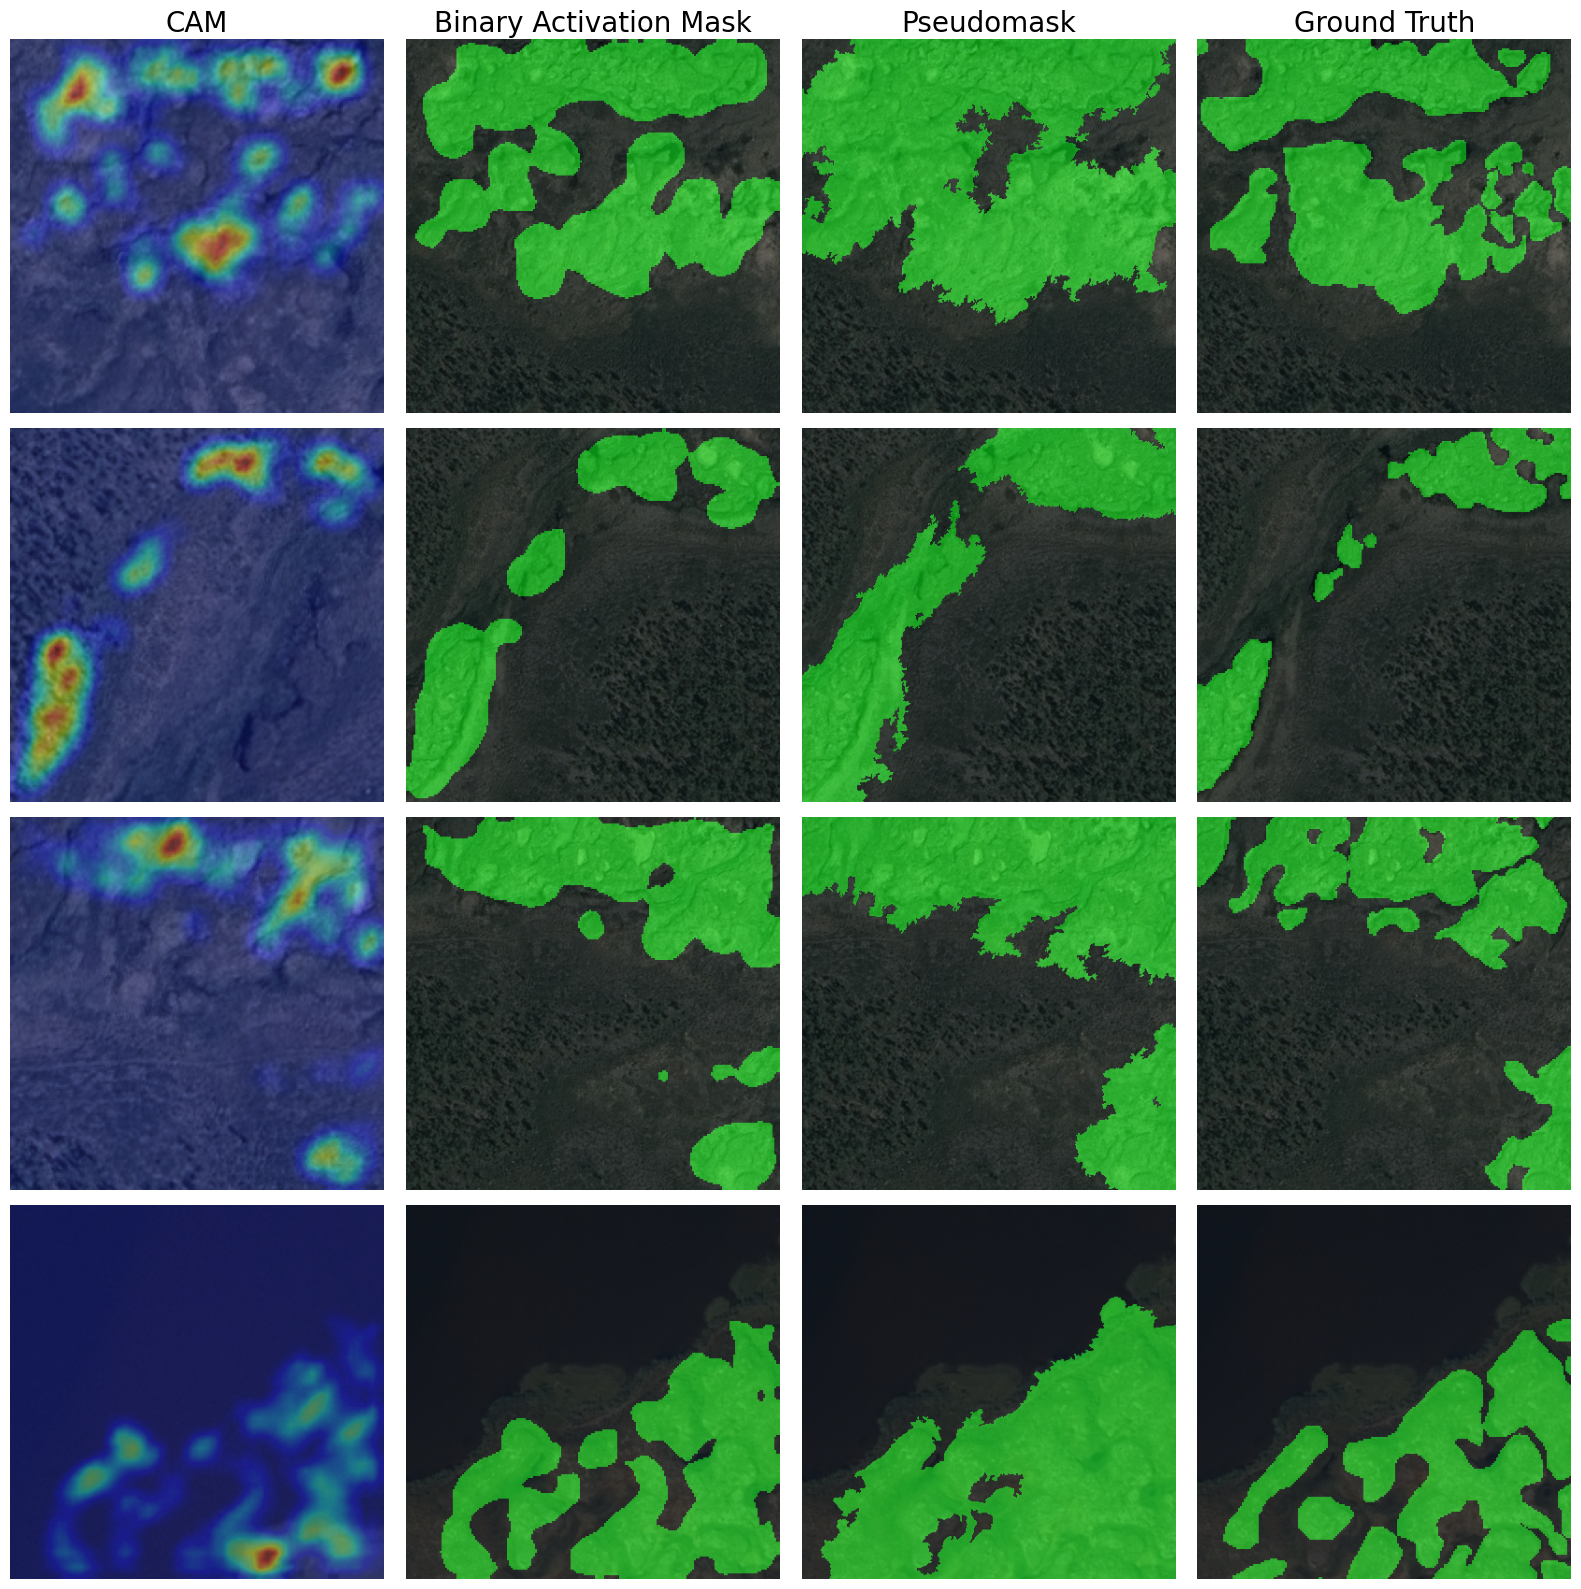

In [23]:
import torch.nn as nn
import matplotlib.pyplot as plt 
from model.pseudomask import Pseudomasks



pseudomask_generator = Pseudomasks(
    dataset, cam_threshold_factor, overlap_threshold,
    snic_seeds, snic_compactness, finetuned = finetune, std_from_mean=0
    )
pseudomask_generator.model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

def plot_segmentation(filenames):

    fig, ax = plt.subplots(4, 4, figsize=(16, 16))

    for row, filename in enumerate(filenames): 

        with rasterio.open(f"/Volumes/USB/FINALFINAL_200m_groundtruths/rgb/{filename}.tif") as RGB_src:
        # Read the image data
            RGB_img = RGB_src.read()

        with rasterio.open(f"/Volumes/USB/FINALFINAL_200m_groundtruths/hs/{filename}.tif") as hs_src:
            # Read the image data
            hs_img = hs_src.read()

        # convert and upsample hs image
        hs_image_array = np.array(hs_img)
        hs_image_tensor = torch.from_numpy(hs_image_array)
        hs_image_tensor = hs_image_tensor.float()
        bilinear = nn.Upsample(size=200*2, mode='bilinear')
        hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0)

        # converting RGB to tensor
        RGB_image_array = np.array(RGB_img)
        RGB_image_tensor = torch.from_numpy(RGB_image_array)
        RGB_image_tensor = RGB_image_tensor.float()

        combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor)).unsqueeze(dim=0)

        #get the last convolution
        sf = SaveFeatures(model.features[-2])
        im = Variable(combined_tensor)
        outputs = model(im)

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach()

        pals_acts = torch.nn.functional.interpolate(
            input = arr[:,1,:,:].unsqueeze(1),
            scale_factor = 4,
            mode='bilinear'
        ).cpu().detach()
        pixels_activated = torch.where(torch.Tensor(pals_acts) > 0.87, 1, 0).squeeze().float().numpy()
        pixels_activated = np.array(Image.fromarray(pixels_activated).resize((400, 400), Image.NEAREST)) 

        cpu_img = combined_tensor.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        pseudomask = pseudomask_generator.generate_mask(combined_tensor, None, False)

        # CAM
        ax[row,0].imshow(cpu_img[:,:,:3])
        ax[row,0].imshow(pals_acts.view(pals_acts.shape[3], pals_acts.shape[3], 1), alpha=.4, cmap='jet')
        ax[row,0].axis('off')
        if row ==0:
            ax[row,0].set_title("CAM", size= 20)

        # Pixels activated
        binary_mask = np.array(RGB_image_tensor.permute(1,2,0)) * 0.5 + np.expand_dims(pixels_activated, axis=2) * np.array([4, 250, 7]) * 0.5
        binary_mask = binary_mask.astype(np.uint8)
        ax[row,1].imshow(binary_mask)
        if row == 0:
            ax[row,1].set_title("Binary Activation Mask", size= 20)
        ax[row,1].axis('off')

        # Pseudomask
        binary_pseudomask = np.array(RGB_image_tensor.permute(1,2,0)) * 0.5 + np.expand_dims(pseudomask, axis=2) * np.array([4, 250, 7]) * 0.5
        binary_pseudomask = binary_pseudomask.astype(np.uint8)
        ax[row,2].imshow(binary_pseudomask)
        if row == 0:
            ax[row,2].set_title("Pseudomask", size= 20)
        ax[row,2].axis('off')

        # Ground truth
        GT = rasterio.open(f"/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/groundtruth_mask/{filename}.tif").read()
        GT = np.squeeze(GT)  # Remove single-dimensional entries
        GT = np.array(Image.fromarray(GT).resize((400, 400), Image.NEAREST))  # Upsample to 400x400
        # GT_overlay = np.array(cpu_img) * 0.5 + np.expand_dims(GT, axis=2) * np.array([4, 250, 7]) * 0.5
        GT_overlay = np.array(RGB_image_tensor.permute(1,2,0)) * 0.5 + np.expand_dims(GT, axis=2) * np.array([4, 250, 7]) * 0.5
        GT_overlay = GT_overlay.astype(np.uint8)
        ax[row,3].imshow(GT_overlay)
        if row == 0:
            ax[row,3].set_title("Ground Truth", size= 20)
        ax[row,3].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
filenames = ['753_67_2550_2014_crop_51','753_67_2550_2014_crop_61','753_67_2550_2014_crop_62', '760_74_5025_2018_crop_48']
plot_segmentation(filenames)


In [9]:
pixels_activated.shape

NameError: name 'pixels_activated' is not defined

In [25]:
color_seg.shape

NameError: name 'color_seg' is not defined